In [1]:
print("all ok")

all ok


In [10]:
import sys, os

# Get project root — one level up from 'research_and_analyst'
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)

print("Project root added to path:", project_root)

Project root added to path: c:\Users\CS\Desktop\LLMOps\automated-research-report-generation


In [4]:
from research_and_analyst.utils.model_loader import ModelLoader


In [5]:
model_loader = ModelLoader()

{"timestamp": "2025-10-25T02:23:52.696466Z", "level": "warning", "event": "OPENAI_API_KEY is missing from environment"}
{"timestamp": "2025-10-25T02:23:52.700156Z", "level": "info", "event": "GOOGLE_API_KEY loaded from environment"}
{"timestamp": "2025-10-25T02:23:52.703146Z", "level": "info", "event": "GROQ_API_KEY loaded from environment"}
{"timestamp": "2025-10-25T02:23:52.705140Z", "level": "info", "event": "ASTRA_DB_API_ENDPOINT loaded from environment"}
{"timestamp": "2025-10-25T02:23:52.708135Z", "level": "info", "event": "ASTRA_DB_APPLICATION_TOKEN loaded from environment"}
{"timestamp": "2025-10-25T02:23:52.711745Z", "level": "info", "event": "ASTRA_DB_KEYSPACE loaded from environment"}
{"config_keys": ["astra_db", "embedding_model", "retriever", "llm"], "timestamp": "2025-10-25T02:23:52.727705Z", "level": "info", "event": "YAML config loaded"}


In [6]:
llm=model_loader.load_llm()

{"provider": "google", "model": "gemini-2.0-flash", "timestamp": "2025-10-25T02:23:56.042515Z", "level": "info", "event": "Loading LLM"}


In [7]:
llm.invoke("hi").content

'Hi there! How can I help you today?'

In [8]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

In [9]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage,HumanMessage , SystemMessage
from langgraph.checkpoint.memory import MemorySaver

#health

Analyst(
        name="Dr. Neha Patel",
        role="Medical Data Scientist",
        affiliation="Stanford Medicine",
        description="Focuses on predictive models for patient outcomes."
        ),
        

Analyst(
    name="Dr. Arun Verma",
    role="Ethics Researcher",
    affiliation="WHO",
    description="Explores ethical implications of AI in diagnostics."



),
Analyst(
    name="Ms. Priya Sharma",
    role="Policy Analyst",
    affiliation="Ministry of Health",
    description="Investigates AI policy and compliance frameworks."
)

In [23]:
class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst.")
    role: str = Field(description="Role of the analyst in the context of the topic.")
    affiliation: str = Field(description="Primary affiliation of the analyst.")
    description: str = Field(description="Description of the analyst focus, concerns, and motives.")
    
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"
    

In [25]:
analyst = Analyst(
    name="CS",
    role="genai eng",
    affiliation="AI Research LAB",
    description="I am genai developer as well as mentor"
    )

In [26]:
analyst.name

'CS'

In [27]:
analyst.role

'genai eng'

In [28]:
analyst.affiliation

'AI Research LAB'

In [29]:
print(analyst.persona)

Name: CS
Role: genai eng
Affiliation: AI Research LAB
Description: I am genai developer as well as mentor



In [40]:
class Perspectives(BaseModel):
       analysts: List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations.")

In [30]:
class GenerateAnalystsState(TypedDict):
    topic: str #research topic
    max_analysts: int # number of analyst
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    

In [31]:
GenerateAnalystsState(
    topic = "finance",
    max_analysts= 5,
    human_analyst_feedback= "give the real info",  
)

{'topic': 'finance',
 'max_analysts': 5,
 'human_analyst_feedback': 'give the real info'}

In [56]:
Analyst(
        name="Dr. Neha Patel",
        role="Medical Data Scientist",
        affiliation="Stanford Medicine",
        description="Focuses on predictive models for patient outcomes."
    ),

(Analyst(name='Dr. Neha Patel', role='Medical Data Scientist', affiliation='Stanford Medicine', description='Focuses on predictive models for patient outcomes.'),)

In [57]:
analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

In [58]:
print([analyst_instructions.format(
        topic="education",
        max_analysts=4,
        human_analyst_feedback="please exaplain only on AI"
        
        )] + ["Generate the set of analysts."])

['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:\n\n1. First, review the research topic:\neducation\n\n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: \n\nplease exaplain only on AI\n\n3. Determine the most interesting themes based upon documents and / or feedback above.\n\n4. Pick the top 4 themes.\n\n5. Assign one analyst to each theme.', 'Generate the set of analysts.']


['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:\n\n1. First, review the research topic:\neducation\n\n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: \n\nplease exaplain only on AI\n\n3. Determine the most interesting themes based upon documents and / or feedback above.\n\n4. Pick the top 4 themes.\n\n5. Assign one analyst to each theme.', 'Generate the set of analysts.']


['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:\n\n1. First, review the research topic:\neducation\n\n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: \n\nplease exaplain only on AI\n\n3. Determine the most interesting themes based upon documents and / or feedback above.\n\n4. Pick the top 4 themes.\n\n5. Assign one analyst to each theme.', 'Generate the set of analysts.']

In [59]:
structured_llm= llm.with_structured_output(Perspectives)

In [42]:
structured_llm.invoke('You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:\n\n1. First, review the research topic:\neducation\n\n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: \n\nplease exaplain only on AI\n\n3. Determine the most interesting themes based upon documents and / or feedback above.\n\n4. Pick the top 4 themes.\n\n5. Assign one analyst to each theme.', 'Generate the set of analysts.')

AttributeError: 'str' object has no attribute 'items'

In [60]:
def create_analyst(state:GenerateAnalystsState):
    """
    it is creating my analyst
    
    """
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback","")
    
    structured_llm = llm.with_structured_output(Perspectives)
    
    system_messages = analyst_instructions.format(
        topic=topic,
        max_analysts=max_analysts,
        human_analyst_feedback=human_analyst_feedback
        
        )
    analysts = structured_llm.invoke([SystemMessage(content=system_messages)]+ [HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}
    

In [61]:
create_analyst(
    {'topic': 'health',
    'max_analysts': 5,
    'human_analyst_feedback': 'give the real info'}
    )

{'analysts': [Analyst(name='Dr. Emily Carter', role='Public Health Researcher', affiliation='National Institutes of Health', description='Focuses on preventative healthcare and the impact of public health policies on community well-being. Concerned with health equity and access to care for underserved populations.'),
  Analyst(name='Dr. Michael Chen', role='Healthcare Economist', affiliation='Harvard Medical School', description='Analyzes healthcare costs, insurance models, and the economic impact of healthcare regulations. Motivated by finding sustainable and efficient healthcare financing solutions.'),
  Analyst(name='Dr. Sarah Johnson', role='Medical Technology Innovator', affiliation='Stanford Bioengineering', description='Develops and evaluates new medical technologies, including AI-driven diagnostics and robotic surgery. Driven by the potential to improve patient outcomes and reduce invasiveness of treatments.'),
  Analyst(name='Dr. David Rodriguez', role='Pharmaceutical Industry

{'analysts': [Analyst(name='Dr. Emily Carter', role='Public Health Researcher', affiliation='National Institutes of Health', description='Focuses on preventative healthcare and the impact of public health policies on community well-being. Concerned with health equity and access to care for underserved populations.'),
  Analyst(name='Dr. Michael Chen', role='Healthcare Economist', affiliation='Harvard Medical School', description='Analyzes healthcare costs, insurance models, and the economic impact of healthcare regulations. Motivated by finding sustainable and efficient healthcare financing solutions.'),
  Analyst(name='Dr. Sarah Johnson', role='Medical Technology Innovator', affiliation='Stanford Bioengineering', description='Develops and evaluates new medical technologies, including AI-driven diagnostics and robotic surgery. Driven by the potential to improve patient outcomes and reduce invasiveness of treatments.'),
  Analyst(name='Dr. David Rodriguez', role='Pharmaceutical Industry Analyst', affiliation='Global Pharma Corp', description='Focuses on drug development, clinical trials, and the market dynamics of the pharmaceutical industry. Concerned with bringing innovative and cost-effective treatments to market.'),
  Analyst(name='Dr. Maria Hernandez', role='Healthcare Policy Advisor', affiliation='Department of Health and Human Services', description='Advises on healthcare policy and regulatory issues, including healthcare reform and access to care. Motivated by creating a more equitable and effective healthcare system for all citizens.')]}

In [54]:
create_analyst(
    {'topic': 'finance',
    'max_analysts': 5,
    'human_analyst_feedback': 'give the real info'}
    )

{'analysts': [Analyst(name='Ava Sharma', role='Quantitative Analyst', affiliation='Hedge Fund X', description='Focuses on developing and backtesting algorithmic trading strategies. Concerned with market volatility and risk management. Motivated by maximizing returns through data-driven insights.'),
  Analyst(name='Ben Carter', role='Financial Regulation Specialist', affiliation='Regulatory Compliance Agency Y', description='Specializes in analyzing and interpreting financial regulations. Concerned with ensuring market stability and preventing illicit financial activities. Motivated by maintaining ethical standards and protecting investors.'),
  Analyst(name='Chloe Davis', role='Investment Strategist', affiliation='Global Investment Bank Z', description='Develops investment strategies based on macroeconomic trends and market analysis. Concerned with identifying growth opportunities and managing portfolio risk. Motivated by achieving long-term capital appreciation for clients.'),
  Analy

In [62]:
def human_feedback(state):
    """ No-op node that should be interrupted on """
    pass

In [63]:
def should_continue(state):
    """ Return the next node to execute """
    human_analyst_feedback = state.get("human_analyst_feedback",None)
    if human_analyst_feedback:
        return "create_analyst"

In [64]:
from IPython.display import Image, display

In [65]:
builder = StateGraph(GenerateAnalystsState)

In [66]:
builder.add_node("create_analyst",create_analyst)
builder.add_node("human_feedback", human_feedback)

In [67]:
builder.add_edge(START,"create_analyst")
builder.add_edge("create_analyst", "human_feedback")
builder.add_conditional_edges("human_feedback",
                        should_continue,
                        ["create_analyst",
                        END])

In [68]:
memory = MemorySaver()

In [69]:
graph = builder.compile(interrupt_before= ["human_feedback"],checkpointer= memory)

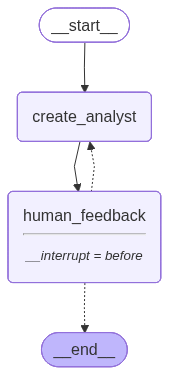

In [70]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [71]:
topic = "the benefits of adopting Langgraph as an agent framework"

In [72]:
max_analysts = 4

In [73]:
thread =  {"configurable":{"thread_id":1}}

In [74]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  
            
        

Name: Alice Chen
Affiliation: Independent AI Lab
Role: AI Research Scientist
Description: Focuses on the technical advantages of Langgraph, such as its ability to manage complex agent interactions and improve the efficiency of multi-agent systems. She is motivated by the potential for Langgraph to advance the state of the art in AI research.
--------------------------------------------------
Name: Bob Johnson
Affiliation: Large Financial Institution
Role: Enterprise Architect
Description: Concerned with the practical benefits of Langgraph for enterprise applications. He evaluates Langgraph based on its scalability, reliability, and ease of integration with existing systems. His primary motive is to reduce development costs and improve the performance of AI-powered services within the institution.
--------------------------------------------------
Name: Charlie Davis
Affiliation: Non-profit AI Ethics Organization
Role: AI Ethics Consultant
Description: Examines the ethical implications 

In [75]:
state = graph.get_state(thread)

In [76]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'analysts': [Analyst(name='Alice Chen', role='AI Research Scientist', affiliation='Independent AI Lab', description='Focuses on the technical advantages of Langgraph, such as its ability to manage complex agent interactions and improve the efficiency of multi-agent systems. She is motivated by the potential for Langgraph to advance the state of the art in AI research.'), Analyst(name='Bob Johnson', role='Enterprise Architect', affiliation='Large Financial Institution', description='Concerned with the practical benefits of Langgraph for enterprise applications. He evaluates Langgraph based on its scalability, reliability, and ease of integration with existing systems. His primary motive is to reduce development costs and improve the performance of AI-powered services within the institution.'), Analyst(name='Charlie Davis', role='AI Ethics Consultant', affiliation='Non-profit AI 

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'analysts': [Analyst(name='Alice Chen', role='AI Research Scientist', affiliation='Independent AI Lab', description='Focuses on the technical advantages of Langgraph, such as its ability to manage complex agent interactions and improve the efficiency of multi-agent systems. She is motivated by the potential for Langgraph to advance the state of the art in AI research.'), Analyst(name='Bob Johnson', role='Enterprise Architect', affiliation='Large Financial Institution', description='Concerned with the practical benefits of Langgraph for enterprise applications. He evaluates Langgraph based on its scalability, reliability, and ease of integration with existing systems. His primary motive is to reduce development costs and improve the performance of AI-powered services within the institution.'), Analyst(name='Charlie Davis', role='AI Ethics Consultant', affiliation='Non-profit AI Ethics Organization', description='Examines the ethical implications of using Langgraph, particularly its potential to create more complex and opaque AI systems. He is motivated by ensuring that Langgraph is used responsibly and that its applications are aligned with ethical principles and societal values.'), Analyst(name='Diana Rodriguez', role='AI Product Manager', affiliation='Tech Startup', description='Interested in the product development aspects of Langgraph. She focuses on how Langgraph can be used to build innovative AI products and services, and how it compares to other agent frameworks in terms of usability and features. Her motive is to leverage Langgraph to gain a competitive advantage in the market.')]}, next=('human_feedback',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b15d6-29ff-6f48-8001-efd384565dce'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-10-25T04:45:09.321300+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b15d5-f2c2-6a6b-8000-84a64b3dc570'}}, tasks=(PregelTask(id='09a13d18-9f63-b05a-5ec0-bbf25f742dc6', name='human_feedback', path=('__pregel_pull', 'human_feedback'), error=None, interrupts=(), state=None, result=None),), interrupts=())


StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'analysts': [Analyst(name='Dr. Emily Chen', role='AI Framework Specialist', affiliation='Institute of Advanced AI Systems', description="Dr. Chen focuses on the technical advantages of adopting Langgraph as an agent framework. Her primary interest lies in how Langgraph enhances the efficiency and scalability of AI systems. She is particularly concerned with the framework's ability to integrate with existing technologies and its potential to streamline complex AI processes."), Analyst(name="Michael O'Neill", role='Enterprise Solutions Consultant', affiliation='Tech Innovations Inc.', description="Michael is interested in the business implications of adopting Langgraph. He explores how the framework can drive innovation and competitive advantage for enterprises. His focus is on cost-effectiveness, return on investment, and the framework's ability to support rapid deployment of AI solutions in various industries."), Analyst(name='Dr. Aisha Patel', role='Ethics and Compliance Analyst', affiliation='Global AI Ethics Consortium', description='Dr. Patel examines the ethical considerations and compliance aspects of using Langgraph. She is concerned with ensuring that the framework adheres to global standards for AI ethics and data privacy. Her analysis includes the potential risks and safeguards associated with deploying Langgraph in sensitive environments.'), Analyst(name='Carlos Ramirez', role='User Experience Researcher', affiliation='Human-Centric AI Lab', description='Carlos focuses on the user experience and accessibility of Langgraph. He investigates how the framework impacts the usability of AI systems for developers and end-users. His primary concern is ensuring that Langgraph is intuitive and accessible, promoting wider adoption and effective use across diverse user groups.')]}, next=('human_feedback',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0a1de3-2570-6c27-8001-9078a254da36'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-10-05T11:26:54.786256+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0a1de2-fb55-6ac3-8000-c6b465b474b8'}}, tasks=(PregelTask(id='91c5d388-aa45-dddb-1ccb-71d005fa101b', name='human_feedback', path=('__pregel_pull', 'human_feedback'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [155]:
state.next

('human_feedback',)

In [156]:
graph.update_state(thread,
                   {"human_analyst_feedback":"add something from the startup perspective and focus on the latest enterprise application"},as_node="human_feedback"
                   )

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0a752d-7632-6dc0-8002-0cc69a4dea37'}}

In [157]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Alice Chen
Affiliation: Independent AI Lab
Role: AI Research Scientist
Description: Focuses on the technical advantages of Langgraph, such as its ability to manage complex agent workflows and improve the efficiency of multi-agent systems. She is motivated by the potential for Langgraph to advance the state of the art in AI research.
--------------------------------------------------
Name: Bob Johnson
Affiliation: Large Financial Institution
Role: Enterprise Architect
Description: Concerned with the practical benefits of Langgraph for enterprise applications. His focus is on how Langgraph can improve the reliability, scalability, and maintainability of AI-powered systems in a business context. He is also interested in the cost savings and ROI that Langgraph can provide.
--------------------------------------------------
Name: Charlie Davis
Affiliation: Non-profit AI Ethics Organization
Role: AI Ethics Consultant
Description: Prioritizes the ethical implications of using Langgraph.

In [158]:
state = graph.get_state(thread)

In [159]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application', 'analysts': [Analyst(name='Ava Chen', role='Startup CTO', affiliation='InnovateAI', description="Focuses on Langgraph's rapid prototyping and deployment capabilities for AI-powered startups, emphasizing its potential to accelerate development cycles and reduce time to market. Concerned with ease of integration, scalability, and cost-effectiveness for early-stage ventures."), Analyst(name='Dr. Ben Carter', role='Enterprise AI Architect', affiliation='GlobalTech Solutions', description="Evaluates Langgraph's suitability for complex enterprise applications, focusing on its ability to manage multi-agent workflows, ensure reliability, and integrate with existing enterprise systems. Prioritizes security, compliance, and governance in large-scale deployments."), Analy

In [160]:
StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application', 'analysts': [Analyst(name='Sophia Tran', role='Startup Ecosystem Analyst', affiliation='Tech Innovators Network', description='Sophia focuses on the impact of adopting new technologies like Langgraph within startup environments. She is particularly interested in how Langgraph can streamline operations, reduce costs, and enhance scalability for emerging companies. Her analysis often includes case studies of startups that have successfully integrated Langgraph into their frameworks.'), Analyst(name='Michael Chen', role='Enterprise Application Specialist', affiliation='Global Enterprise Solutions', description='Michael specializes in the latest enterprise applications and how frameworks like Langgraph can be leveraged to improve efficiency and innovation. He examines the integration of Langgraph in large-scale operations, focusing on its ability to enhance data processing and decision-making capabilities in complex enterprise environments.'), Analyst(name='Aisha Patel', role='AI Framework Researcher', affiliation='Institute of Advanced AI Studies', description="Aisha's research delves into the technical benefits of adopting Langgraph as an agent framework. She explores its architecture, flexibility, and how it compares to other frameworks in terms of performance and adaptability. Her work is aimed at understanding the underlying mechanisms that make Langgraph a preferred choice for AI developers."), Analyst(name="Liam O'Reilly", role='Business Strategy Consultant', affiliation='FutureTech Consulting', description='Liam provides insights into the strategic advantages of adopting Langgraph from a business perspective. He focuses on how Langgraph can drive competitive advantage, foster innovation, and support strategic goals. His analysis includes market trends and the potential return on investment for companies considering Langgraph.')]}, next=('human_feedback',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0a1df1-04f5-6064-8005-d0c1ee02664c'}}, metadata={'source': 'loop', 'step': 5, 'parents': {}}, created_at='2025-10-05T11:33:07.189770+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0a1df0-cf09-6eeb-8004-d34c3b72cfb8'}}, tasks=(PregelTask(id='db47106a-d166-d3ef-32d5-2d7ac449ca66', name='human_feedback', path=('__pregel_pull', 'human_feedback'), error=None, interrupts=(), state=None, result=None),), interrupts=())

NameError: name 'StateSnapshot' is not defined

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application', 'analysts': [Analyst(name='Sophia Tran', role='Startup Ecosystem Analyst', affiliation='Tech Innovators Network', description='Sophia focuses on the impact of adopting new technologies like Langgraph within startup environments. She is particularly interested in how Langgraph can streamline operations, reduce costs, and enhance scalability for emerging companies. Her analysis often includes case studies of startups that have successfully integrated Langgraph into their frameworks.'), Analyst(name='Michael Chen', role='Enterprise Application Specialist', affiliation='Global Enterprise Solutions', description='Michael specializes in the latest enterprise applications and how frameworks like Langgraph can be leveraged to improve efficiency and innovation. He examines the integration of Langgraph in large-scale operations, focusing on its ability to enhance data processing and decision-making capabilities in complex enterprise environments.'), Analyst(name='Aisha Patel', role='AI Framework Researcher', affiliation='Institute of Advanced AI Studies', description="Aisha's research delves into the technical benefits of adopting Langgraph as an agent framework. She explores its architecture, flexibility, and how it compares to other frameworks in terms of performance and adaptability. Her work is aimed at understanding the underlying mechanisms that make Langgraph a preferred choice for AI developers."), Analyst(name="Liam O'Reilly", role='Business Strategy Consultant', affiliation='FutureTech Consulting', description='Liam provides insights into the strategic advantages of adopting Langgraph from a business perspective. He focuses on how Langgraph can drive competitive advantage, foster innovation, and support strategic goals. His analysis includes market trends and the potential return on investment for companies considering Langgraph.')]}, next=('human_feedback',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0a1df1-04f5-6064-8005-d0c1ee02664c'}}, metadata={'source': 'loop', 'step': 5, 'parents': {}}, created_at='2025-10-05T11:33:07.189770+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0a1df0-cf09-6eeb-8004-d34c3b72cfb8'}}, tasks=(PregelTask(id='db47106a-d166-d3ef-32d5-2d7ac449ca66', name='human_feedback', path=('__pregel_pull', 'human_feedback'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [161]:
state.next

('human_feedback',)

In [162]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback":further_feedack}, as_node="human_feedback")

KeyError: None

In [163]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [164]:

final_state.next

('human_feedback',)